Protein-Protein Interaction (PPI) Prediction
This notebook explores the PPI dataset, validates the data integrity, and trains a Random Forest model using various class-imbalance techniques (Class Weights, SMOTE, and SMOTE-Tomek)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Set visualization style
sns.set_theme(style="whitegrid")

Data Loading and Validation

First, we load the dataset and perform sanity checks to ensure probabilities and surface accessibility values are within their expected logical ranges.

In [46]:
ppi_data = pd.read_csv("ppi.csv")
display(ppi_data.head())

def check_dataframe(ppi_data):
    
    prob_cols = [col for col in ppi_data.columns if 'prob_' in col]
    surf_cols = [col for col in ppi_data.columns if 'surf_acc' in col]

    #check if there's any NaN value in the dataset
    ppi_data.isnull().values.any()
    
    #chekc probbilities value correctness
    prob_issues = 0
    for col in prob_cols:
        invalid_count = ((ppi_data[col] < 0) | (ppi_data[col] > 1)).sum()
        if invalid_count > 0:
            print(f"{col}: {invalid_count} values outside 0 and 1")
            prob_issues += 1
            
    if prob_issues == 0:
        print("probability columns have all values within range")

    #chekc psurface values correctness
    surf_issues = 0
    for col in surf_cols:
        invalid_count = (ppi_data[col] < 0).sum()
        if invalid_count > 0:
            print(f"{col}: {invalid_count} negative values")
            surf_issues += 1
            
    if surf_issues == 0:
        print("Surface columns have all values within range")

print(check_dataframe(ppi_data))


,Unnamed: 0,domain,aa_ProtPosition,uniprot_id,Rlength,sequence,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,0,1,A0A024RAV5,188,M,0.238095,0.784319,0.711111,0.803,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,1,0,2,A0A024RAV5,188,T,0.238095,0.359207,0.422222,0.530,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,2,0,3,A0A024RAV5,188,E,0.238095,0.395387,0.111111,0.464,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
3,3,0,4,A0A024RAV5,188,Y,0.238095,0.401655,0.355556,0.385,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
4,4,1,5,A0A024RAV5,188,K,0.238095,0.288103,0.066667,0.287,...,0.302858,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0


probability columns have all values within range
Surface columns have all values within range
None


Preprocessing and Train/Test Split

To prevent data leakage, we split the data based on unique proteins (`uniprot_id`) rather than randomized rows. 33% of the proteins are for testing, 66% for training.

In [47]:
# class imbalance for total datset
counts = ppi_data['p_interface'].value_counts()
percentages = ppi_data['p_interface'].value_counts(normalize=True) * 100
print(counts)
print(percentages)

# Get list of unique proteins (228 total)
unique_proteins = ppi_data['uniprot_id'].unique()

# Split proteins (33% test, 67% train)
train_ids, test_ids = train_test_split(unique_proteins, test_size=0.33, random_state=22)
train_data = ppi_data[ppi_data['uniprot_id'].isin(train_ids)]
test_data = ppi_data[ppi_data['uniprot_id'].isin(test_ids)]

# Drop features not used for modeling
cols_to_drop = ['p_interface', 'uniprot_id', 'domain', 'sequence', 'aa_ProtPosition', 'Unnamed: 0']
  
X_train = train_data.drop(columns=cols_to_drop)
y_train = train_data['p_interface']
X_test = test_data.drop(columns=cols_to_drop)
y_test = test_data['p_interface']

# Check class imbalance
print("--- TARGET CLASS IMBALANCE ---")
print(f"Train Balance:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\nTest Balance:\n{y_test.value_counts(normalize=True) * 100}")
print(f"\nShapes: X_train: {X_train.shape} | X_test: {X_test.shape}")


p_interface
0    57305
1     7845
Name: count, dtype: int64
p_interface
0    87.958557
1    12.041443
Name: proportion, dtype: float64
--- TARGET CLASS IMBALANCE ---
Train Balance:
p_interface
0    87.955821
1    12.044179
Name: proportion, dtype: float64

Test Balance:
p_interface
0    87.964179
1    12.035821
Name: proportion, dtype: float64

Shapes: X_train: (43822, 132) | X_test: (21328, 132)


In [48]:
#pre-processing

# get the list of all unique proteins (228 total)
unique_proteins = ppi_data['uniprot_id'].unique()

# takes 33% of the total proteins for test set, 67% in the training, n.22
train_ids, test_ids = train_test_split(unique_proteins, test_size=0.33, random_state=22)
train_data = ppi_data[ppi_data['uniprot_id'].isin(train_ids)]
test_data = ppi_data[ppi_data['uniprot_id'].isin(test_ids)]

# some fetaures have to be dropped
cols_to_drop = ['p_interface', 'uniprot_id', 'domain', 'sequence', 'aa_ProtPosition', 'Unnamed: 0']
  
X_train = train_data.drop(columns=cols_to_drop)
y_train = train_data['p_interface']

X_test = test_data.drop(columns=cols_to_drop)
y_test = test_data['p_interface']

# 1. Just call .value_counts() directly on the Series
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# 2. Get the proportions (percentages) to easily check the imbalance
train_props = y_train.value_counts(normalize=True) * 100
test_props = y_test.value_counts(normalize=True) * 100

# 3. Print everything out clearly
print("--- RAW COUNTS ---")
print("Train 0s and 1s:\n", train_counts, "Train Class Balance:\n", train_props)
print("\nTest 0s and 1s:\n", test_counts, "\nTest Class Balance:\n", test_props)

print("\nShapes:", X_train.shape, X_test.shape)

--- RAW COUNTS ---
Train 0s and 1s:
 p_interface
0    38544
1     5278
Name: count, dtype: int64 Train Class Balance:
 p_interface
0    87.955821
1    12.044179
Name: proportion, dtype: float64

Test 0s and 1s:
 p_interface
0    18761
1     2567
Name: count, dtype: int64 
Test Class Balance:
 p_interface
0    87.964179
1    12.035821
Name: proportion, dtype: float64

Shapes: (43822, 132) (21328, 132)


Model Training and Handling Imbalance

Because the `p_interface` target is highly imbalanced, we will evaluate a Random Forest classifier using three different techniques:
1. Built-in Class Weights
2. SMOTE (Synthetic Minority Over-sampling Technique)
3. SMOTE-Tomek (Over-sampling combined with under-sampling)

In [49]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=22, n_jobs=-1)
rf_balanced.fit(X_train, y_train)
pred_balanced = rf_balanced.predict(X_test)

smote = SMOTE(random_state=23)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=23, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
pred_smote = rf_smote.predict(X_test)

smt = SMOTETomek(random_state=24)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
rf_smt = RandomForestClassifier(n_estimators=100, random_state=24, n_jobs=-1)
rf_smt.fit(X_train_smt, y_train_smt)
pred_smt = rf_smt.predict(X_test)

print("Class Weight Balanced:")
print(classification_report(y_test, pred_balanced))
print("SMOTE:")
print(classification_report(y_test, pred_smote))
print("SMOTE Tomek:")
print(classification_report(y_test, pred_smt))

Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     18761
           1       0.52      0.01      0.03      2567

    accuracy                           0.88     21328
   macro avg       0.70      0.51      0.48     21328
weighted avg       0.84      0.88      0.83     21328

SMOTE:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     18761
           1       0.27      0.07      0.12      2567

    accuracy                           0.87     21328
   macro avg       0.58      0.52      0.52     21328
weighted avg       0.81      0.87      0.83     21328

SMOTE Tomek:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     18761
           1       0.30      0.07      0.12      2567

    accuracy                           0.87     21328
   macro avg       0.59      0.53      0.52     21328
weighted avg       0.82      0.

In [50]:
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef, f1_score

def evaluate_model(model, X_test, y_test):

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "MCC": mcc,
        "F1": f1,
        "y_prob": y_prob
    }
results = {}

results["RF + class_weight"] = evaluate_model(rf_balanced, X_test, y_test)
results["RF + SMOTE"] = evaluate_model(rf_smote, X_test, y_test)
results["RF + SMOTETomek"] = evaluate_model(rf_smt, X_test, y_test)

summary_table = pd.DataFrame({
    method: {
        "ROC-AUC": results[method]["ROC-AUC"],
        "PR-AUC": results[method]["PR-AUC"],
        "MCC": results[method]["MCC"],
        "F1": results[method]["F1"],
    }
    for method in results
}).T

summary_table


,ROC-AUC,PR-AUC,MCC,F1
RF + class_weight,0.667985,0.212833,0.066629,0.027988
RF + SMOTE,0.678562,0.211580,0.094366,0.129630
RF + SMOTETomek,0.678528,0.210949,0.099679,0.128915


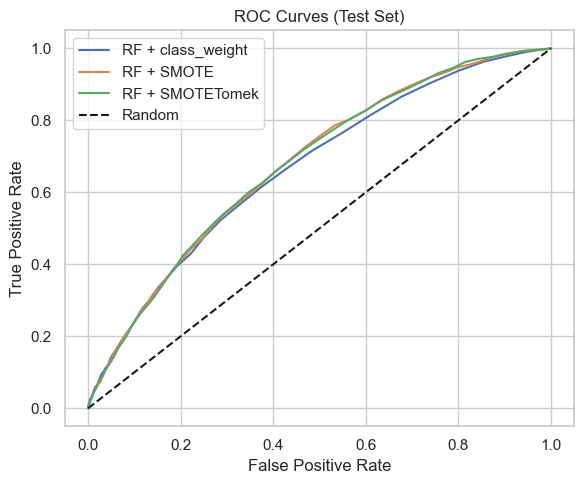

In [51]:
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(6,5))

for method, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=method)

plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


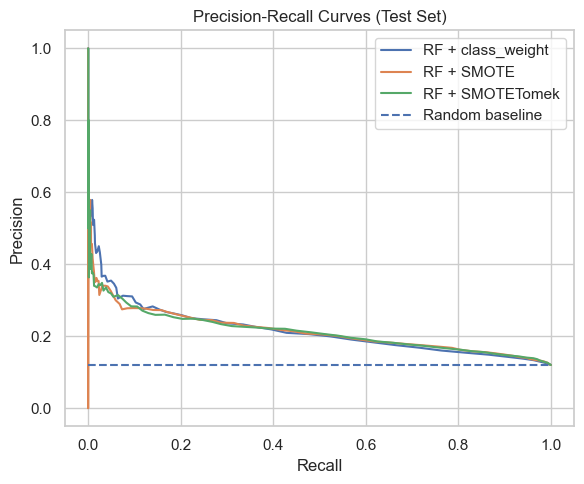

In [52]:
plt.figure(figsize=(6,5))

for method, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
    plt.plot(recall, precision, label=method)

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles='dashed', label="Random baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split

if "train_df" in globals() and "uniprot_id" in train_df.columns:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = train_df["uniprot_id"].values

    train_idx, val_idx = next(gss.split(train_df, train_df["p_interface"], groups=groups))

    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    print("Using protein-level validation split by uniprot_id.")
else:
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    print("Using random stratified validation split (fallback).")

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Pos ratio train/val/test:", y_tr.mean(), y_val.mean(), y_test.mean())


Using random stratified validation split (fallback).
Train: (35057, 132) Val: (8765, 132) Test: (21328, 132)
Pos ratio train/val/test: 0.1204324385999943 0.12047917855105533 0.1203582145536384


In [ ]:

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import numpy as np




def make_xgb(scale_pos_weight=None, random_state=42):
    return XGBClassifier(
        n_estimators=800,          
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=random_state,
        eval_metric="aucpr"
    )


if "results" not in globals():
    results = {}


neg = (y_tr == 0).sum()
pos = (y_tr == 1).sum()
spw = neg / max(pos, 1)

xgb_spw = make_xgb(scale_pos_weight=spw)
xgb_spw.fit(X_tr, y_tr)

results["XGB + scale_pos_weight"] = evaluate_model(xgb_spw, X_test, y_test)



smote = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)


xgb_smote = make_xgb(scale_pos_weight=1.0)
xgb_smote.fit(X_tr_sm, y_tr_sm)

results["XGB + SMOTE"] = evaluate_model(xgb_smote, X_test, y_test)




st = SMOTETomek(random_state=42)
X_tr_st, y_tr_st = st.fit_resample(X_tr, y_tr)

xgb_st = make_xgb(scale_pos_weight=1.0)
xgb_st.fit(X_tr_st, y_tr_st)

results["XGB + SMOTETomek"] = evaluate_model(xgb_st, X_test, y_test)


summary_table = pd.DataFrame({
    method: {
        "ROC-AUC": results[method]["ROC-AUC"],
        "PR-AUC": results[method]["PR-AUC"],
        "MCC": results[method]["MCC"],
        "F1": results[method]["F1"],
    }
    for method in results
}).T


order = [
    "RF + class_weight",
    "RF + SMOTE",
    "RF + SMOTETomek",
    "XGB + scale_pos_weight",
    "XGB + SMOTE",
    "XGB + SMOTETomek",
]


order = [m for m in order if m in summary_table.index]

summary_table_ordered = summary_table.loc[order]
summary_table_ordered





,ROC-AUC,PR-AUC,MCC,F1
RF + class_weight,0.667985,0.212833,0.066629,0.027988
RF + SMOTE,0.678562,0.211580,0.094366,0.129630
RF + SMOTETomek,0.678528,0.210949,0.099679,0.128915
XGB + scale_pos_weight,0.659869,0.212721,0.147353,0.260494
XGB + SMOTE,0.669735,0.219016,0.084187,0.079011
XGB + SMOTETomek,0.671423,0.217958,0.081940,0.075354


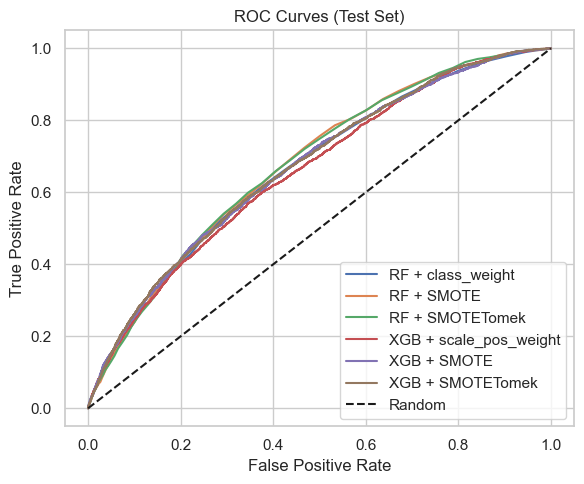

In [57]:
plt.figure(figsize=(6,5))

for method in order:
    y_prob = results[method]["y_prob"]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=method)

plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()



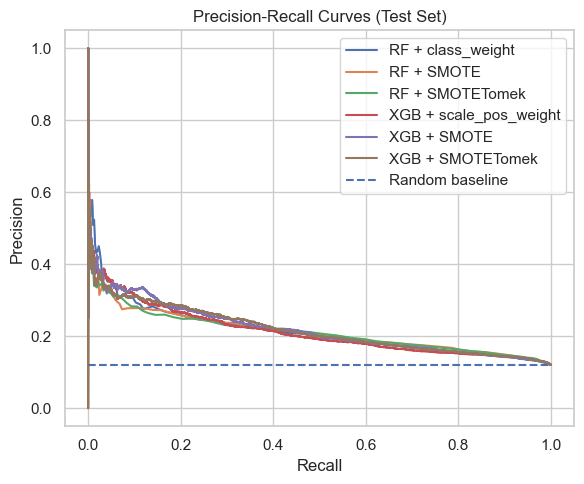

In [58]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# PR curve
plt.figure(figsize=(6,5))

if "results" in globals():
    for method, res in results.items():
        precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
        plt.plot(recall, precision, label=method)
else:
    precision, recall, _ = precision_recall_curve(y_test, xgb_res["y_prob"])
    plt.plot(recall, precision, label="XGBoost")

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles='dashed', label="Random baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier



def best_threshold(y_true, y_prob, metric="mcc"):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_s = 0.5, -1e9

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        if metric == "mcc":
            s = matthews_corrcoef(y_true, y_pred)
        elif metric == "f1":
            s = f1_score(y_true, y_pred)
        else:
            raise ValueError("metric must be 'mcc' or 'f1'")

        if s > best_s:
            best_s = s
            best_t = t

    return best_t, best_s



def eval_at_threshold(y_true, y_prob, t):
    y_pred = (y_prob >= t).astype(int)
    return {
        "MCC": matthews_corrcoef(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
    }



def fit_rf_class_weight(X, y):
    m = RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1,
        class_weight="balanced"
    )
    return m.fit(X, y)

def fit_rf_smote(X, y):
    Xr, yr = SMOTE(random_state=42).fit_resample(X, y)
    m = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    return m.fit(Xr, yr)

def fit_rf_smotetomek(X, y):
    Xr, yr = SMOTETomek(random_state=42).fit_resample(X, y)
    m = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    return m.fit(Xr, yr)



def make_xgb(scale_pos_weight=None):
    return XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42,
        eval_metric="aucpr"
    )

def fit_xgb_scale_pos_weight(X, y):
    neg = (y == 0).sum()
    pos = (y == 1).sum()
    spw = neg / max(pos, 1)
    m = make_xgb(scale_pos_weight=spw)
    return m.fit(X, y)

def fit_xgb_smote(X, y):
    Xr, yr = SMOTE(random_state=42).fit_resample(X, y)
    m = make_xgb(scale_pos_weight=1.0)
    return m.fit(Xr, yr)

def fit_xgb_smotetomek(X, y):
    Xr, yr = SMOTETomek(random_state=42).fit_resample(X, y)
    m = make_xgb(scale_pos_weight=1.0)
    return m.fit(Xr, yr)



methods = {
    "RF + class_weight": fit_rf_class_weight,
    "RF + SMOTE": fit_rf_smote,
    "RF + SMOTETomek": fit_rf_smotetomek,
    "XGB + scale_pos_weight": fit_xgb_scale_pos_weight,
    "XGB + SMOTE": fit_xgb_smote,
    "XGB + SMOTETomek": fit_xgb_smotetomek,
}

rows = []

for name, trainer in methods.items():
    model = trainer(X_tr, y_tr)


    prob_val = model.predict_proba(X_val)[:, 1]
    prob_test = model.predict_proba(X_test)[:, 1]

  
    t_mcc, val_mcc = best_threshold(y_val, prob_val, metric="mcc")
    test_eval_mcc = eval_at_threshold(y_test, prob_test, t_mcc)


    t_f1, val_f1 = best_threshold(y_val, prob_val, metric="f1")
    test_eval_f1 = eval_at_threshold(y_test, prob_test, t_f1)

    rows.append({
        "Method": name,

        "Best t (val) for MCC": round(t_mcc, 2),
        "Val MCC@t": val_mcc,
        "Test MCC@t": test_eval_mcc["MCC"],
        "Test F1@t": test_eval_mcc["F1"],

        "Best t (val) for F1": round(t_f1, 2),
        "Val F1@t": val_f1,
        "Test MCC@t_F1": test_eval_f1["MCC"],
        "Test F1@t_F1": test_eval_f1["F1"],

        
        "Test ROC-AUC": roc_auc_score(y_test, prob_test),
        "Test PR-AUC": average_precision_score(y_test, prob_test),
    })

threshold_table = pd.DataFrame(rows)


order = [
    "RF + class_weight", "RF + SMOTE", "RF + SMOTETomek",
    "XGB + scale_pos_weight", "XGB + SMOTE", "XGB + SMOTETomek"
]
threshold_table["Method"] = pd.Categorical(threshold_table["Method"], categories=order, ordered=True)
threshold_table = threshold_table.sort_values("Method")

threshold_table


,Method,Best t (val) for MCC,Val MCC@t,Test MCC@t,Test F1@t,Best t (val) for F1,Val F1@t,Test MCC@t_F1,Test F1@t_F1,Test ROC-AUC,Test PR-AUC
0,RF + class_weight,0.16,0.384383,0.162700,0.285021,0.16,0.454965,0.162700,0.285021,0.673317,0.219370
1,RF + SMOTE,0.29,0.329881,0.170447,0.292732,0.33,0.412198,0.170848,0.290476,0.680107,0.218634
2,RF + SMOTETomek,0.29,0.334187,0.166063,0.289606,0.34,0.418169,0.163671,0.283513,0.682035,0.216237
3,XGB + scale_pos_weight,0.46,0.351045,0.152623,0.271985,0.52,0.434469,0.151243,0.259408,0.659869,0.212721
4,XGB + SMOTE,0.18,0.326598,0.164984,0.286608,0.19,0.411726,0.164042,0.284408,0.669735,0.219016
5,XGB + SMOTETomek,0.16,0.328906,0.162447,0.286553,0.19,0.415021,0.167036,0.286658,0.671423,0.217958
